In [2]:
using Gen
using Random
using CairoMakie
using Distributions
using StatsBase

#### Helper functions

In [78]:
const Card = Union{Symbol, Int}
const State = Tuple{Int, Card, Bool}
const Policy = Dict{State, Float64}

CARD_MAP = [:ace, :two, :three, :four, :five, :six, :seven, :eight, :nine, :ten, :jack, :queen, :king]

function sort_hand(hand)
    # aces should be last
    return sort(hand, lt=(x,y) -> x != :ace)
end

function get_value(card, sum_so_far)
    if card == :ace
        if sum_so_far + 11 <= 21
            return 11
        else
            return 1
        end
    elseif card == :jack || card == :queen || card == :king
        return 10
    else
        # get index in card map
        return findfirst(x -> x == card, CARD_MAP)
    end
end

function get_sum(hand)
    hand = sort_hand(hand)
    sum = 0
    for card in hand
        sum += get_value(card, sum)
    end
    return sum
end

function holds_usable_ace(hand)
    hand = sort_hand(hand)
    sum = 0
    for card in hand
        value = get_value(card, sum)    
        if value == 11
            return true
        end
        sum += value
    end
    return false
end

function states()
    states = []
    for i in 4:21
        for j in 1:13
            for k in [true, false]
                push!(states, (i, CARD_MAP[j], k))
            end
        end
    end
    return states
end

STATES = states();

function plot_policy(policy::Policy)
    
    # Define ranges for player sums and dealer showing cards
    player_sums = 12:21  # x-axis
    dealer_showing = 1:13  # y-axis

    # Initialize z-values based on the policy
    z_true = zeros(Float64, length(player_sums), length(dealer_showing))
    z_false = zeros(Float64, length(player_sums), length(dealer_showing))

    # Populate z-values based on the policy
    for i in player_sums
        for j in dealer_showing
            card = CARD_MAP[j]
            z_true[i - 11, j] = policy[(i, card, true)]
            z_false[i - 11, j] = policy[(i, card, false)]
        end
    end

    # Create figure
    fig = Figure(resolution = (800, 600))

    # Surface plot with usable ace
    ax1 = Axis3(fig[1, 1], title = "Usable Ace")
    surface!(ax1, player_sums, dealer_showing, z_true)
    ax1.xlabel = "Player sum"
    ax1.ylabel = "Dealer showing"
    ax1.zlabel = "1 = Hit, 0 = Stick"

    # Surface plot without usable ace
    ax2 = Axis3(fig[1, 2], title = "No Usable Ace")
    surface!(ax2, player_sums, dealer_showing, z_false)
    ax2.xlabel = "Player sum"
    ax2.ylabel = "Dealer showing"
    ax2.zlabel = "1 = Hit, 0 = Stick"

    # Display the figure
    display(fig)
end

function most_frequent_policy(dict_list::Vector{Policy})
    # Dictionary to count occurrences of each dictionary
    dict_counts = Dict{Policy, Int}()
    
    for d in dict_list
        # Increment count for each dictionary
        dict_counts[d] = get(dict_counts, d, 0) + 1
    end
    
    # Find the dictionary with the maximum count
    most_frequent = argmax(dict_counts)
    
    return most_frequent, dict_counts[most_frequent]  # Return the most frequent dict and its count
end

function plot_mode_policy(traces)

    most_frequent, count = most_frequent_policy([get_retval(trace) for trace in traces])

    println("Most frequent policy occurred $count times")

    plot_policy(most_frequent)
end;

function plot_mean_policy(traces)
    mean_pol = Policy()
    for state in STATES 
        mean_pol[state] = mean(Float64[run[:ret => :policy => state] for run in traces if has_value(get_choices(run), :ret => :policy => state)])
    end

    print(mean_pol)
    plot_policy(mean_pol)
end;


#### Helper distributions

In [35]:
@dist function draw_card()
    card = uniform_discrete(1,13)
    CARD_MAP[card]
end;


## Model

In [23]:
@gen function blackjack_model()
    sum = 0
    actions = Dict{State, Int}()
    policy = Policy()

    # Player
    card1 = {:card => 1} ~ draw_card()
    card2 = {:card => 2} ~ draw_card()
    hand = [card1, card2]

    # Dealer
    dealer_first_card = {:dealer => 1} ~ draw_card()
    dealer_visible_card = {:dealer => 2} ~ draw_card()

    sum = get_sum(hand)
    state = (sum, dealer_visible_card, holds_usable_ace(hand))

    # Player's turn
    for i in 3:11 
        card = {:card => i} ~ draw_card()
        policy[state] = {:policy => state} ~ beta(1,1)
        actions[state] = {:action => state} ~ bernoulli(policy[state])
        if actions[state] == 1
            push!(hand, card)
            sum = get_sum(hand)
            state = (sum, dealer_visible_card, holds_usable_ace(hand))
            if sum > 21
                break
            end
        else
            break
        end
    end

    # Dealer's turn
    dealer_hand = [dealer_first_card, dealer_visible_card]
    dealer_sum = get_sum(dealer_hand)
    for i in 3:11
        card = {:dealer => i} ~ draw_card()
        push!(dealer_hand, card)
        dealer_sum = get_sum(dealer_hand)
        if dealer_sum >= 17
            break
        end
    end
    
    # Determine winner
    if sum > 21
        return 1
    elseif dealer_sum > 21
        return 100
    elseif sum > dealer_sum
        return 100
    elseif sum < dealer_sum
        return 1
    else
        return 50
    end

end;

In [24]:
trace = simulate(blackjack_model, ())
get_retval(trace)

100

### Simulations

In [25]:
@gen function run_game()
    # play one game according to this policy
    ret = {:ret} ~ blackjack_model()

    # ret is either 1, 50 or 100 --> transform to Bernoulli
    p = ret / 100 # max reward = 100

    o ~ bernoulli(p)
    
end;

Sampling from policy_select conditional on o = 1 will produce a marginal distribution on policies that is proportional to their expected return.

--> only need to sample from the conditional and pick the policy that occurs most frequently

In [26]:
trace = simulate(run_game, ())


Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##run_game#230", Bool[], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:o => Gen.ChoiceOrCallRecord{Bool}(false, -0.01005033585350145, NaN, true), :ret => Gen.ChoiceOrCallRecord{Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}}(Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##blackjack_model#229", Bool[], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(), Dict{Any, Trie{Any, Gen.ChoiceOrCallRecord}}(:dealer => Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(4 => Gen.ChoiceOrCallRecord{Symbol}(:jack, -2.5649493574615367, NaN, true), 2 => Gen.ChoiceOrCallRecord{Symbol}(:two, -2.5649493574615367, NaN, true), 3 => Gen.ChoiceOrCallRecord{Symbol}(:eight

#### Rejection Sampling

In [57]:
conditioned = []
for i in 1:1e5
    run = simulate(run_game, ())
    if run[:o] == 1
        push!(conditioned, run)
    end
end
length(conditioned)

42813

Dict{Tuple{Int64, Union{Int64, Symbol}, Bool}, Float64}((20, :queen, 1) => 0.4355774683531453, (8, :ten, 0) => 0.4813546687172454, (9, :three, 1) => NaN, (20, :king, 0) => 0.363473267645301, (19, :five, 1) => 0.4991084462864206, (21, :ace, 0) => 0.3505422861795775, (11, :nine, 0) => 0.48908849649982167, (11, :two, 1) => NaN, (15, :three, 0) => 0.41729955744476305, (17, :eight, 0) => 0.4047401852108617, (12, :four, 0) => 0.49034996723244867, (9, :queen, 1) => NaN, (14, :ten, 0) => 0.3968074711436039, (9, :king, 0) => 0.4595385768786552, (10, :nine, 0) => 0.4256204658922587, (6, :three, 0) => 0.4831049973751483, (10, :two, 1) => NaN, (5, :jack, 0) => 0.49369955210874905, (12, :six, 0) => 0.47086156463124257, (15, :eight, 0) => 0.415199958701773, (8, :three, 1) => NaN, (20, :nine, 0) => 0.33666262873222147, (20, :two, 1) => 0.38260429190879547, (12, :six, 1) => 0.4642582084540174, (5, :nine, 1) => NaN, (17, :five, 1) => 0.44271784044166906, (21, :four, 1) => 0.4592934526128027, (12, :king

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/gG38B/src/scenes.jl:227


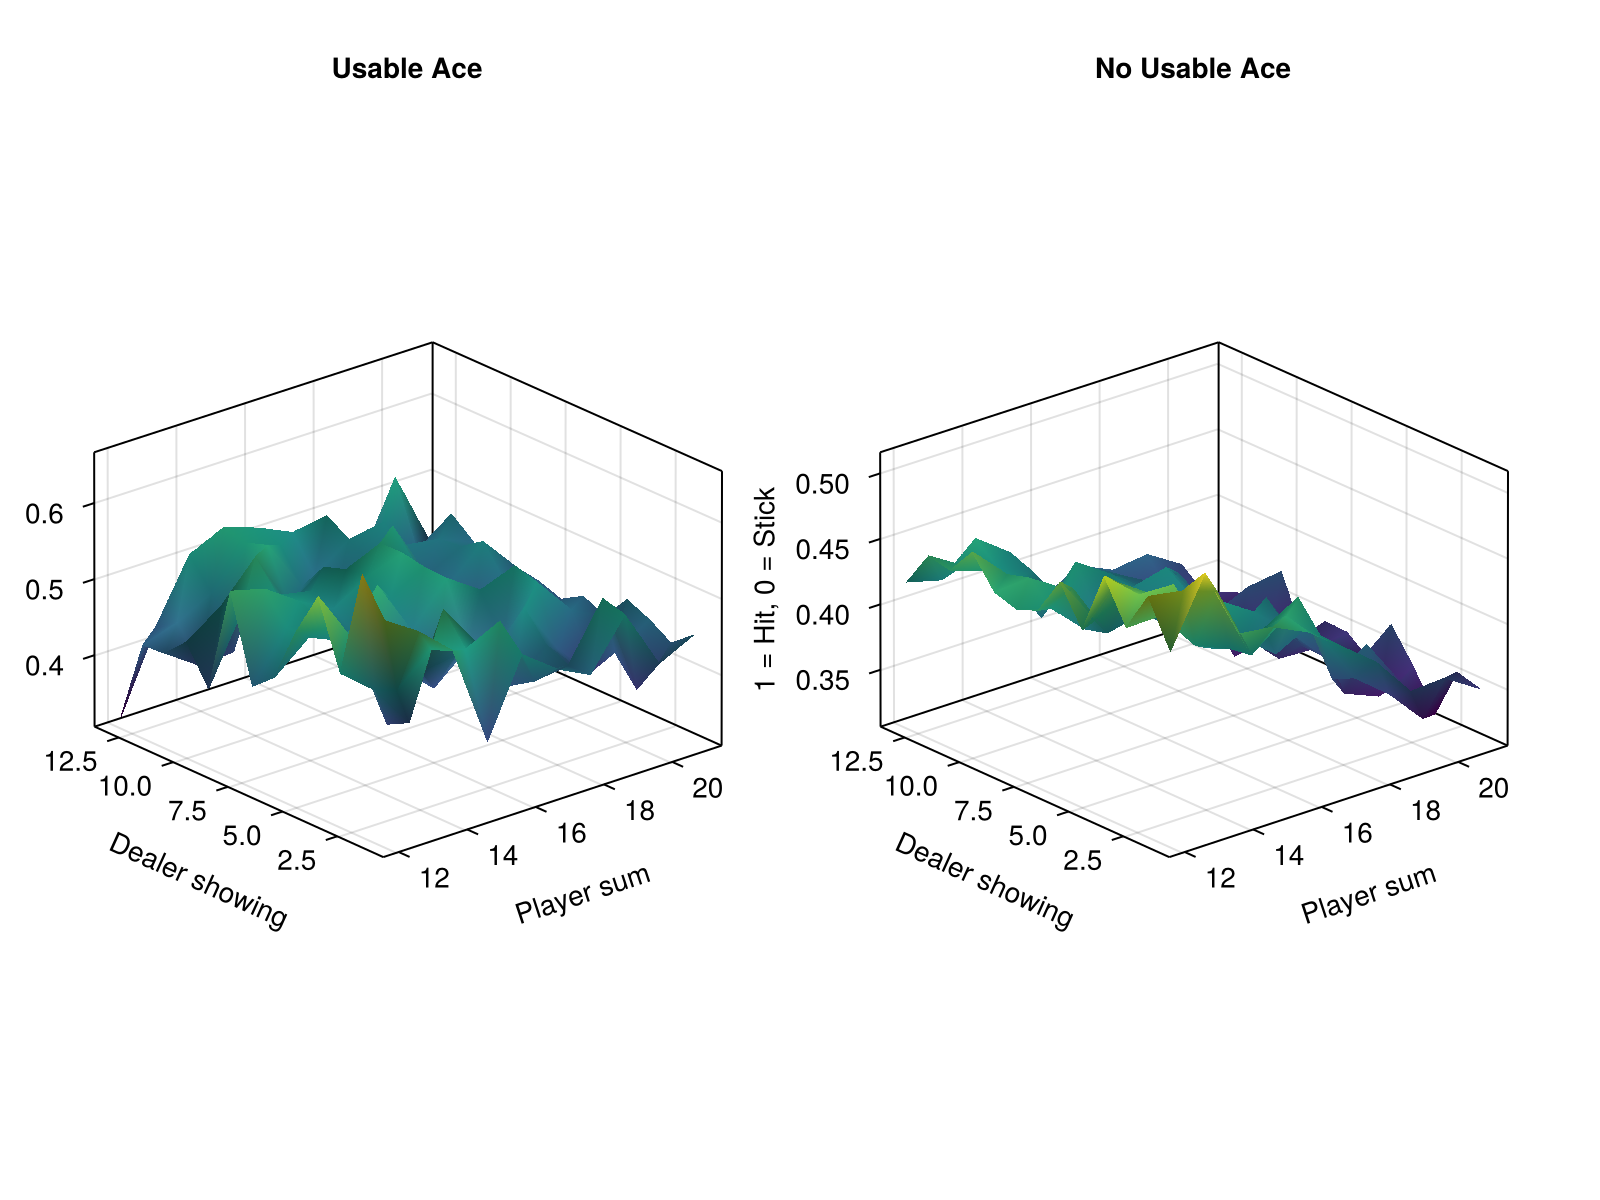

CairoMakie.Screen{IMAGE}


In [79]:
plot_mean_policy(conditioned)


### MCMC

In [80]:
@gen function proposal(curr_trace, state, kappa)
    curr_val = curr_trace[:policy => state]
    α = curr_val * kappa
    β = (1 - curr_val) * kappa
    policy = {:policy => state} ~ beta(α, β)
end

function block_update(trace)
    # update policy
    for s in STATES
        (trace,_) = mh(trace, Gen.select(:policy => s)) 
        (trace,_) = mh(trace, Gen.select(:ret => :action => s)) 
    end

    for t in 1:11
        (trace,_) = mh(trace, Gen.select(:ret => :card => t))
        (trace,_) = mh(trace, Gen.select(:ret => :dealer => t))
    end
    
    return trace
end
function drift_update(trace)
    # update policy
    for s in STATES
        (trace,_) = mh(trace, proposal, (s, 1)) 
        (trace,_) = mh(trace, Gen.select(:ret => :action => s)) 
    end

    for t in 1:11
        (trace,_) = mh(trace, Gen.select(:ret => :card => t))
        (trace,_) = mh(trace, Gen.select(:ret => :dealer => t))
    end
    
    return trace
end

drift_update (generic function with 1 method)

In [87]:
(trace,_) = generate(run_game,(), choicemap((:o,1)))

# trace[:policy => (20, :king, false)]
# trace[:ret => :action => (20, :king, false)]
# trace[:ret => :dealer => 11]

# get_retval(trace)

traces = [trace]
for _ in 1:1e4
    trace = block_update(trace)
    push!(traces,trace)
end
traces

10001-element Vector{Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}}:
 Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##run_game#230", Bool[], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:o => Gen.ChoiceOrCallRecord{Bool}(true, 0.0, NaN, true), :ret => Gen.ChoiceOrCallRecord{Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}}(Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##blackjack_model#229", Bool[], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(), Dict{Any, Trie{Any, Gen.ChoiceOrCallRecord}}(:dealer => Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(2 => Gen.ChoiceOrCallRecord{Symbol}(:queen, -2.5649493574615367, NaN, true), 3 => Gen.ChoiceOrCallRecord{Symbol}(:eight, -2.5649493574615367, 

Dict{Tuple{Int64, Union{Int64, Symbol}, Bool}, Float64}((20, :queen, 1) => 0.5030042433222764, (8, :ten, 0) => 0.5460232638482335, (9, :three, 1) => NaN, (20, :king, 0) => 0.3671635122964548, (19, :five, 1) => 0.4518146750105397, (21, :ace, 0) => 0.3427051249628503, (11, :nine, 0) => 0.4337042304278132, (11, :two, 1) => NaN, (15, :three, 0) => 0.49452447174980146, (17, :eight, 0) => 0.44317815281141815, (12, :four, 0) => 0.5295613596162183, (9, :queen, 1) => NaN, (14, :ten, 0) => 0.39919357721837506, (9, :king, 0) => 0.46770644746879425, (10, :nine, 0) => 0.522773588921262, (6, :three, 0) => 0.34487833456068345, (10, :two, 1) => NaN, (5, :jack, 0) => 0.6818917934052313, (12, :six, 0) => 0.44665566900613596, (15, :eight, 0) => 0.4288864209026551, (8, :three, 1) => NaN, (20, :nine, 0) => 0.3730170832039447, (20, :two, 1) => 0.3924895592301987, (12, :six, 1) => 0.7768656027066747, (5, :nine, 1) => NaN, (17, :five, 1) => 0.39021393215245487, (21, :four, 1) => 0.4412709144303109, (12, :king

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/gG38B/src/scenes.jl:227


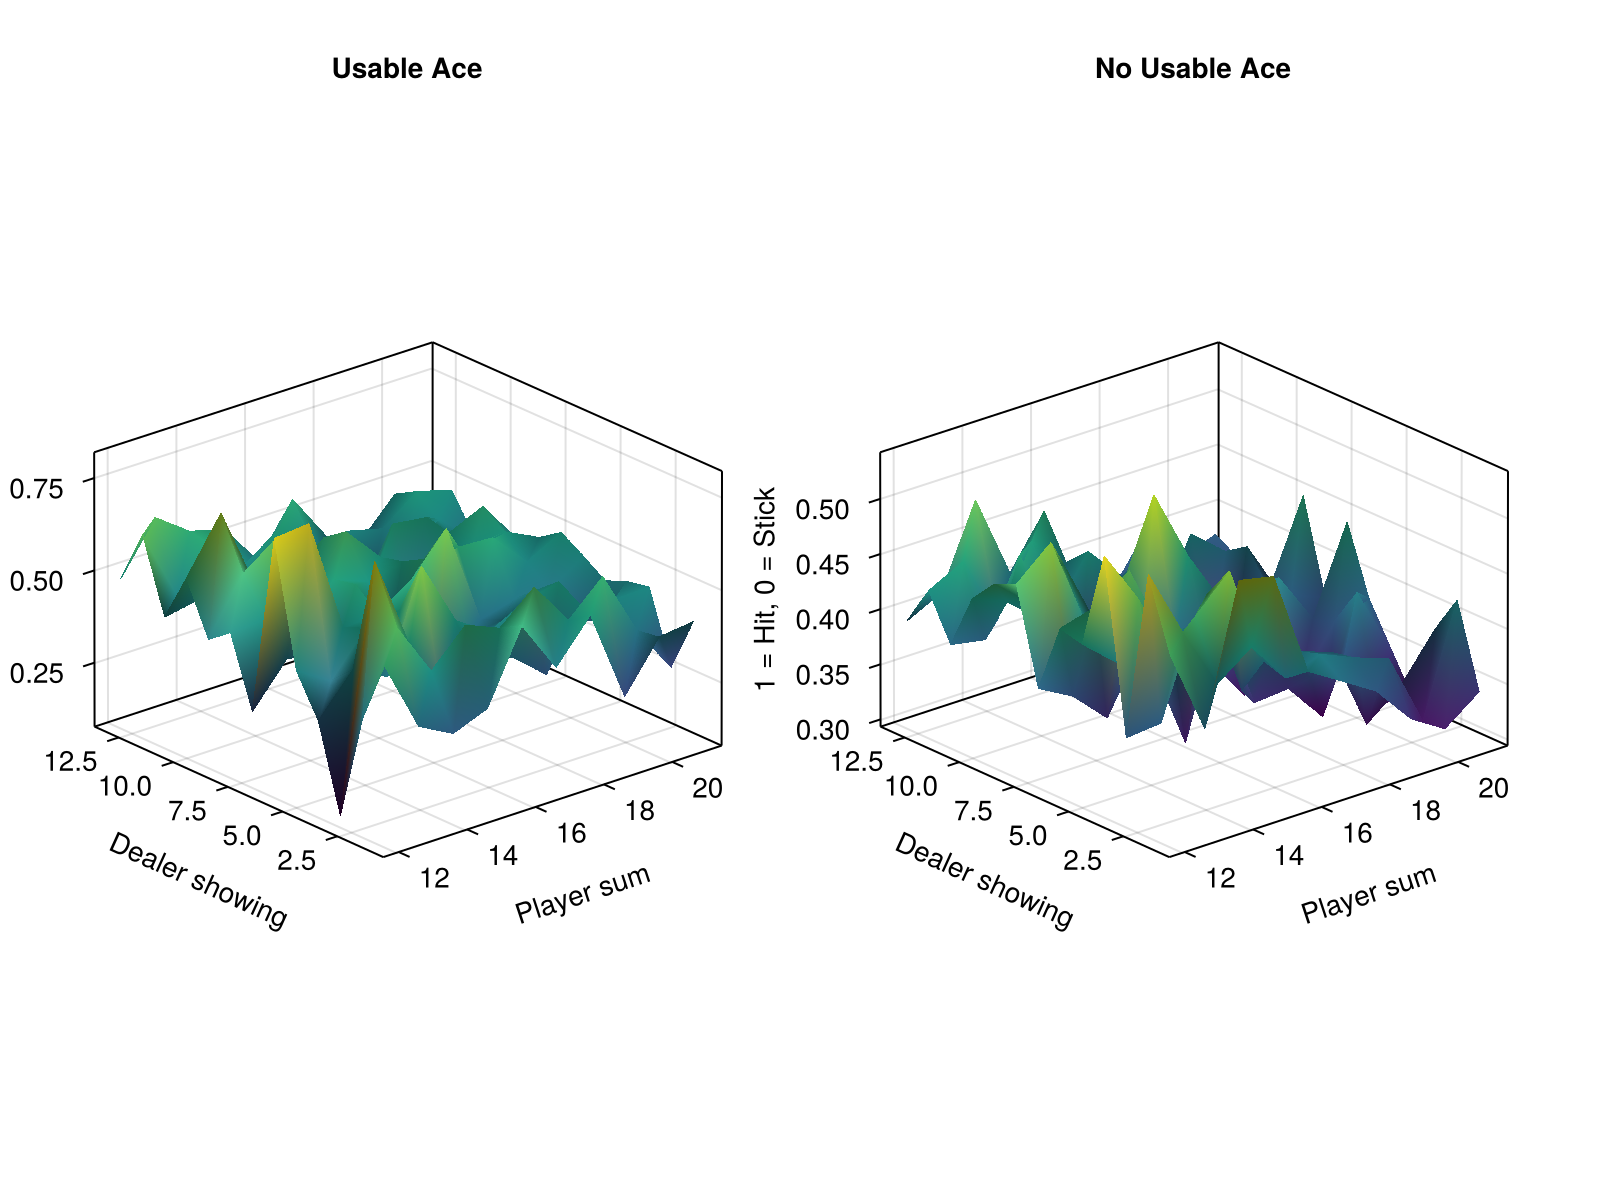

CairoMakie.Screen{IMAGE}


In [88]:
plot_mean_policy(traces)

Dict{Tuple{Int64, Union{Int64, Symbol}, Bool}, Float64}((20, :queen, 1) => 0.8935732803966658, (8, :ten, 0) => 0.34955653112903506, (9, :three, 1) => NaN, (20, :king, 0) => 0.4116977084356055, (19, :five, 1) => NaN, (21, :ace, 0) => 0.3301817292937499, (11, :nine, 0) => 0.3829063778352362, (11, :two, 1) => NaN, (15, :three, 0) => 0.6037440519045361, (17, :eight, 0) => 0.4027444339415799, (12, :four, 0) => 0.6956036209891499, (9, :queen, 1) => NaN, (14, :ten, 0) => 0.42589903958740516, (9, :king, 0) => 0.3746905729435841, (10, :nine, 0) => 0.32755687377758397, (6, :three, 0) => 0.2872081735315833, (10, :two, 1) => NaN, (5, :jack, 0) => NaN, (12, :six, 0) => 0.360593901673565, (15, :eight, 0) => 0.449899235448467, (8, :three, 1) => NaN, (20, :nine, 0) => 0.5215694911477328, (20, :two, 1) => 0.12929648772568764, (12, :six, 1) => NaN, (5, :nine, 1) => NaN, (17, :five, 1) => 0.4954448936671512, (21, :four, 1) => 0.6274153312451984, (12, :king, 1) => 0.08502119236140153, (8, :queen, 1) => Na

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/gG38B/src/scenes.jl:227


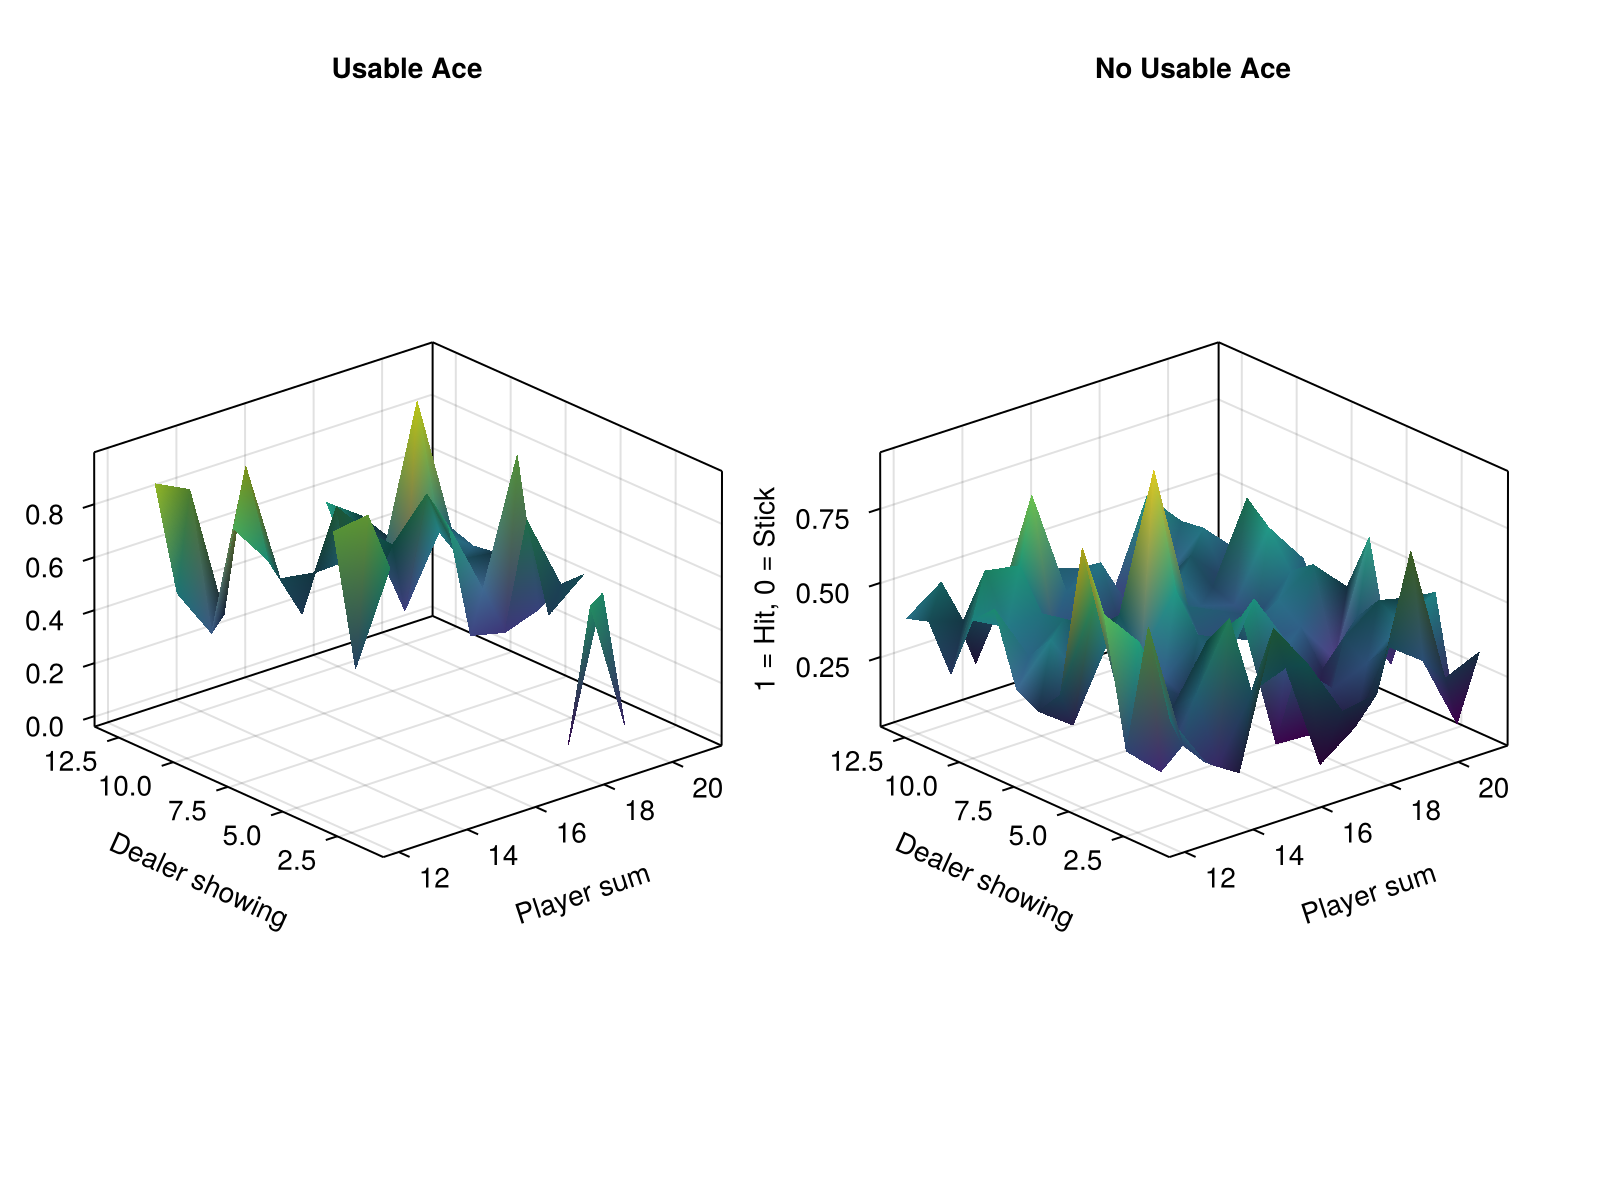

CairoMakie.Screen{IMAGE}


In [89]:
plot_mean_policy(traces[end-1000:end])